In [128]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
tf.set_random_seed(7)
np.random.seed(7)
import time
from tqdm import tqdm
import pickle
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import Counter
import os
from tensorflow.contrib.rnn import LSTMCell as Cell

In [2]:
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/srikanth_sarma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/srikanth_sarma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/srikanth_sarma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
train = pd.read_csv('data/train_stories.csv')
val = pd.read_csv('data/cloze_test_val__spring2016 - cloze_test_ALL_val.csv')
test = pd.read_csv('data/cloze_test_test__spring2016 - cloze_test_ALL_test.csv')

train = train.drop("storytitle", axis=1).drop("storyid", axis=1)

val = val.drop("InputStoryid", axis=1)
val_answer = val["AnswerRightEnding"]
val_sentences = val.drop("AnswerRightEnding", axis=1)

test = test.drop("InputStoryid", axis=1)
test_answer = test["AnswerRightEnding"]
test_sentences = test.drop("AnswerRightEnding", axis=1)

In [4]:
train.head()

,sentence1,sentence2,sentence3,sentence4,sentence5
0,Kelly found her grandmother's pizza recipe in ...,Kelly reminisced about how much she loved her ...,Kelly decided that she was going to try to mak...,Kelly studied the recipe and gathered everythi...,Kelly successfully made a pizza from her grand...
1,Leo wore a toupee and was anxious about it.,He decided to go out for a short walk.,"It was a very windy day, but he wasn't too con...","Suddenly, a strong wind came through and took ...","His dog leaped and caught it, and he quickly r..."
2,Jimmy was a master with his grill.,He spent every weekend getting better with his...,One day he was offered a TV show about grillin...,Jimmy accepted the job in an instant.,He quit his day job and spent all his time gri...
3,Tom and Beth were dating.,Tom wanted to go on a fun date.,Tom suggested ice skating.,His date was excited and they went ice skating.,Tom and Beth grew closer during their ice skat...
4,I had a friend that I didn't know well but let...,She paid rent then asked for some of it back.,She drinks my juice and eats my food.,She also makes a huge mess and is very sloppy.,She got kicked out in two weeks.


In [8]:
train.size

440805

In [9]:
val.size

13097

In [118]:
def get_stories_as_lists(dataframe):
    a = time.time()
    print("Reading stories to memory ...")
    stories = []
    stories_flat = []
    for index, row in dataframe.iterrows():
        story = []
        for col in dataframe.columns:
            story.append(word_tokenize(row[col]))
        stories.append(story)
    print("Done in {} s".format(time.time() - a))
    return stories

def sentence_sentiment(sentence, sentiment_analyzer):
    n_positive = 0
    n_negative = 0
#     sentiment_analyzer = SentimentIntensityAnalyzer()
    for word in sentence:
        sentiment = sentiment_analyzer.polarity_scores(word)
        if sentiment['pos']>sentiment['neg'] and sentiment['pos']>sentiment['neu']:
            n_positive+=1
        elif sentiment['neg']>sentiment['pos'] and sentiment['neg']>sentiment['neu']:
            n_negative+=1
        else:
            continue
    return np.sign(n_positive-n_negative)+1

def sentiment_features(begining, body, climax, option1, option2, P1, P2, P3, P4, sentiment_analyzer):
    s_begining = sentence_sentiment(begining, sentiment_analyzer)
    s_body = sentence_sentiment(body, sentiment_analyzer)
    s_climax = sentence_sentiment(climax, sentiment_analyzer)
    s_option1 = sentence_sentiment(option1, sentiment_analyzer)
    s_option2 = sentence_sentiment(option2, sentiment_analyzer)
    s_context = sentence_sentiment(begining+body+climax, sentiment_analyzer)
    
    features = np.zeros(12)
    
    features[0] = P1[s_option1, s_begining, s_body, s_climax]
    features[1] = P2[s_option1, s_body, s_climax]
    features[2] = P3[s_option1, s_climax]
    features[3] = P4[s_option1, s_context]
    
    features[4] = P1[s_option2, s_begining, s_body, s_climax]
    features[5] = P2[s_option2, s_body, s_climax]
    features[6] = P3[s_option2, s_climax]
    features[7] = P4[s_option2, s_context]
    
    features[8] = 0 if features[0]>features[4] else 1
    features[9] = 0 if features[1]>features[5] else 1
    features[10] = 0 if features[2]>features[6] else 1
    features[11] = 0 if features[3]>features[7] else 1
    
    return features

def generate_vocab(train_stories, vocab_size, vocab_file, corpus_file):
    a = time.time()
    count = 0
    corpus = []
    all_tokens = []
    for i in tqdm(range(len(train_stories))):
        story = train_stories[i]
        events = ['<bos>']
        for sentence in story:
            sentence_pos = nltk.pos_tag(sentence)
            for word_pos in sentence_pos:
                if 'NN' in word_pos[1] or 'PR' in word_pos[1] or 'VB' in word_pos[1]:
                    events.append(word_pos[0])
                    all_tokens.append
        
        corpus.append(events)
        all_tokens.extend(events)
    
    token2count = Counter(all_tokens).most_common(vocab_size)
    vocab_tokens = ['<unk>']
    vocab_tokens.extend([token for token, count in token2count])
    token2id = {token: i for i, token in enumerate(vocab_tokens)}
    id2token = {i: token for token, i in token2id.items()}
    print("Writing Vocabulary Object ... ")
    vocab_dict = {"vocab_size": vocab_size, "token2id": token2id, "id2token": id2token}
    dump(vocab_file, vocab_dict)
    corpus_dict = {"corpus_size": len(corpus), "tokenized_events": corpus}
    dump(corpus_file, corpus_dict)
    print("Done in {} s".format(time.time() - a))
    
    return token2id, id2token, corpus
    
def dump(write_to_file, dictionary):
    out_file = os.path.join(os.getcwd(), write_to_file) # full path
    with open(out_file, "wb+") as f: # dump object
        pickle.dump(dictionary, f, protocol=pickle.HIGHEST_PROTOCOL)
    

def sentiment_features_train(train_stories):
    a = time.time()
    P1 = np.zeros((3,3,3,3))
    P2 = np.zeros((3,3,3))
    P3 = np.zeros((3,3))
    P4 = np.zeros((3,3))
    sentiment_analyzer = SentimentIntensityAnalyzer()
    
    for i in tqdm(range(len(train_stories))):
        story = train_stories[i]
        begining = story[0]
        body = story[1] + story[2]
        climax = story[3]
        ending = story[4]
        s_begining = sentence_sentiment(begining, sentiment_analyzer)
        s_body = sentence_sentiment(body, sentiment_analyzer)
        s_climax = sentence_sentiment(climax, sentiment_analyzer)
        s_ending = sentence_sentiment(ending, sentiment_analyzer)
        s_context = sentence_sentiment(begining+body+climax, sentiment_analyzer)
        
        P1[s_ending, s_begining, s_body, s_climax]+=1
        P2[s_ending, s_body, s_climax]+=1
        P3[s_ending, s_climax]+=1
        P4[s_ending, s_context]+=1
    
    P1 /= np.sum(P1, axis=0)
    P2 /= np.sum(P2, axis=0)
    P3 /= np.sum(P3, axis=0)
    P4 /= np.sum(P4, axis=0)
    
    print("Done in {} s".format(time.time() - a))
    
    return P1, P2, P3, P4
    

def pos_split(sentences):
    sentences_pos = nltk.pos_tag(sentences)
    sentences_nouns = []
    sentences_verbs = []
    for word_pos in sentences_pos:
        if 'NN' in word_pos[1] or 'PR' in word_pos[1]:
            sentences_nouns.append(word_pos[0])
        elif 'VB' in word_pos[1]:
            sentences_verbs.append(word_pos[0])
    
    return sentences_nouns, sentences_verbs

def extract_event_embeddings(sentences, encoder):
    sentences_pos = nltk.pos_tag(sentences)
    sentences_event_embeds = []
    for word_pos in sentences_pos:
        if 'NN' in word_pos[1] or 'PR' in word_pos[1] or 'VB' in word_pos[1]:
            sentences_event_embeds.append(encoder[word_pos[0]])
    
    return sentences_event_embeds

def topical_consistency(context, option1, option2, encoder):
    context_nouns, context_verbs = pos_split(context)
    option1_nouns, option1_verbs = pos_split(option1)
    option2_nouns, option2_verbs = pos_split(option2)
    
    encoded_context_nouns = [encoder[context_noun] for context_noun in context_nouns]
    encoded_option1_nouns = [encoder[option1_noun] for option1_noun in option1_nouns]
    encoded_option2_nouns = [encoder[option2_noun] for option2_noun in option2_nouns]
    encoded_context_verbs = [encoder[context_verb] for context_verb in context_verbs]
    encoded_option1_verbs = [encoder[option1_verb] for option1_verb in option1_verbs]
    encoded_option2_verbs = [encoder[option2_verb] for option2_verb in option2_verbs]
    
    option1_nouns_similarity_matrix = cosine_similarity(encoded_option1_nouns, encoded_context_nouns)
    option2_nouns_similarity_matrix = cosine_similarity(encoded_option2_nouns, encoded_context_nouns)
    option1_verbs_similarity_matrix = cosine_similarity(encoded_option1_verbs, encoded_context_verbs)
    option2_verbs_similarity_matrix = cosine_similarity(encoded_option2_verbs, encoded_context_verbs)
    
    option1_nouns_similarity = np.max(option1_nouns_similarity_matrix, axis=1)
    option2_nouns_similarity = np.max(option2_nouns_similarity_matrix, axis=1)
    option1_verbs_similarity = np.max(option1_verbs_similarity_matrix, axis=1)
    option2_verbs_similarity = np.max(option2_verbs_similarity_matrix, axis=1)
    
    option1_score = np.mean(np.concatenate(option1_nouns_similarity,option1_verbs_similarity))
    option2_score = np.mean(np.concatenate(option2_nouns_similarity,option2_verbs_similarity))
    
    comparative = 0 if option1_score>option2_score else 1
    
    return option1_score, option2_score, comparative

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [22]:
train_stories = get_stories_as_lists(train)

Reading stories to memory ...
Done in 797.9813842773438 s


In [40]:
P1, P2, P3, P4 = sentiment_features_train(train_stories)


  0%|          | 164/88161 [00:04<44:03, 33.28it/s]Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/srikanth_sarma/.conda/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/srikanth_sarma/.local/lib/python3.5/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/srikanth_sarma/.conda/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 88161/88161 [40:18<00:00, 36.45it/s]


Done in 2418.6640543937683 s


In [41]:
pkl_file = open('sentement_params.pkl', 'wb')

data = {'P1':P1, 'P2': P2, 'P3': P3, 'P4': P4}

pickle.dump(data, pkl_file)
pkl_file.close()

In [44]:
P4[0,1] + P4[1,1] + P4[2,1]

1.0

In [45]:
gloveFile = './glove.6B.50d.txt'
encoder = loadGloveModel(gloveFile)

Loading Glove Model
Done. 400000  words loaded!


In [48]:
val_sentences.head()

,InputSentence1,InputSentence2,InputSentence3,InputSentence4,RandomFifthSentenceQuiz1,RandomFifthSentenceQuiz2
0,Rick grew up in a troubled household.,"He never found good support in family, and tur...",It wasn't long before Rick got shot in a robbery.,The incident caused him to turn a new leaf.,He is happy now.,He joined a gang.
1,Laverne needs to prepare something for her fri...,She decides to bake a batch of brownies.,She chooses a recipe and follows it closely.,Laverne tests one of the brownies to make sure...,The brownies are so delicious Laverne eats two...,Laverne doesn't go to her friend's party.
2,Sarah had been dreaming of visiting Europe for...,She had finally saved enough for the trip.,She landed in Spain and traveled east across t...,She didn't like how different everything was.,Sarah then decided to move to Europe.,Sarah decided that she preferred her home over...
3,Gina was worried the cookie dough in the tube ...,She was very happy to find she was wrong.,The cookies from the tube were as good as from...,Gina intended to only eat 2 cookies and save t...,Gina liked the cookies so much she ate them al...,Gina gave the cookies away at her church.
4,It was my final performance in marching band.,I was playing the snare drum in the band.,We played Thriller and Radar Love.,The performance was flawless.,I was very proud of my performance.,I was very ashamed of my performance.


In [47]:
valid_stories = get_stories_as_lists(val_sentences)

Reading stories to memory ...
Done in 22.334588289260864 s


In [99]:
a = time.time()
sentiment_analyzer = SentimentIntensityAnalyzer()
n = len(valid_stories)
features = np.zeros((n, 12))
y = np.zeros(n, dtype = int)
for i in tqdm(range(n)):
    story = valid_stories[i]
    begining = story[0]
    body = story[1] + story[2]
    climax = story[3]
    option1 = story[4]
    option2 = story[5]
    
    sf = sentiment_features(begining, body, climax, option1, option2, P1, P2, P3, P4, sentiment_analyzer)
    
    context = begining + body + climax
    
#     tf = topical_consistency(context, option1, option2, encoder)
    
#     features[i] = np.concatenate((sf, tf))
    features[i] = sf
    
    y[i] = val_answer[i]-1

print("Done in {} s".format(time.time() - a))

100%|██████████| 1871/1871 [00:54<00:00, 34.29it/s]

Done in 54.696404695510864 s


In [100]:
y[0:10]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1])

In [101]:
class LogisticRegressionClass():
    def __init__(self, learning_rate=0.01, stopping_criterion=0.01, max_epochs=1000):
        self.learning_rate = learning_rate
        self.stopping_criterion = stopping_criterion
        self.max_epochs = max_epochs
        self.w = None
    
    def fit(self, x, y):
        m = x.shape[0]
        n = x.shape[1]
        self.w = np.random.randn(n)
        gradient = np.zeros(n)
        cost = np.zeros(self.max_epochs)
        
        for epoch in tqdm(range(0,self.max_epochs)):
            for i in range(0,m):
                y_hat=expit(np.dot(self.w,x[i,:]))
                gradient=(y_hat-y[i])*x[i,:]
                self.w-=self.learning_rate*gradient
                cost[epoch]-=(y[i]*np.log(y_hat)+(1-y[i])*np.log(1-y_hat))
        
        plt.plot(cost)
        return self.w
    
    def predict(self, x):
        m = x.shape[0]
        n = x.shape[1]
        y = np.zeros(m)
        for i in range(0,m):
            y[i] = 1 if expit(np.dot(self.w,x[i,:]))<0.5 else 2
        
        return y

In [102]:
model = LogisticRegressionClass()

100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


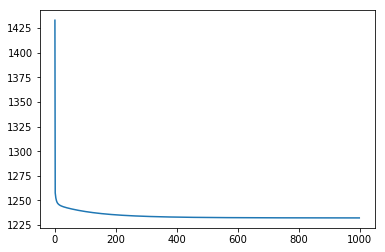

In [103]:
w = model.fit(features, y)

In [104]:
y_pred = model.predict(features)

print(accuracy_score(y+1, y_pred))

0.5847140566541956


In [81]:
test_stories = get_stories_as_lists(test_sentences)

Reading stories to memory ...
Done in 21.386431217193604 s


In [105]:
a = time.time()
sentiment_analyzer = SentimentIntensityAnalyzer()
n = len(test_stories)
test_features = np.zeros((n, 12))
y_gt = np.zeros(n, dtype = int)
for i in tqdm(range(n)):
    story = test_stories[i]
    begining = story[0]
    body = story[1] + story[2]
    climax = story[3]
    option1 = story[4]
    option2 = story[5]
    
    sf = sentiment_features(begining, body, climax, option1, option2, P1, P2, P3, P4, sentiment_analyzer)
    
    context = begining + body + climax
    
#     tf = topical_consistency(context, option1, option2, encoder)
    
#     features[i] = np.concatenate((sf, tf))
    test_features[i] = sf
    
    y_gt[i] = test_answer[i]

print("Done in {} s".format(time.time() - a))

100%|██████████| 1871/1871 [00:53<00:00, 34.71it/s]

Done in 54.02568602561951 s


In [106]:
y_pred = model.predict(test_features)

print(accuracy_score(y_gt, y_pred))

0.5713522180652058


In [86]:
y_pred[0:10]

array([1.52086746, 1.42205282, 1.74531345, 1.57993736, 1.434772  ,
       1.46124831, 1.38297441, 1.5098553 , 1.39829538, 1.33655118])

In [107]:
import sys

In [109]:
sys.getsizeof(train)

44901828

In [119]:
vocab_size = 20000
vocab_file = './vocab.pkl'
corpus_file = './corpus.pkl'
token2id, id2token, corpus = generate_vocab(train_stories, vocab_size, vocab_file, corpus_file)

100%|██████████| 88161/88161 [40:38<00:00, 36.15it/s]


Writing Vocabulary Object ... 
Done in 2443.131096124649 s


In [137]:
class Model():
    def __init__(self, hidden_size=512, embedding_size=100, vocab_size=20000):
        self.dtype = tf.float32
        initializer = tf.contrib.layers.xavier_initializer(dtype=self.dtype)
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.W = tf.Variable(initializer((hidden_size, vocab_size)), name="W", dtype=self.dtype)
        self.biases = tf.Variable(initializer([vocab_size]), name="biases", dtype=self.dtype)
        
        self.embedding_matrix = tf.Variable(initializer((vocab_size, embedding_size)), name="embedding",
                                                dtype=self.dtype)
        self.rnn = Cell(num_units=hidden_size, initializer=initializer, name="cell")
        self.c_in = tf.placeholder(tf.float32, shape=[1, self.rnn.state_size.c], name='c_in')
        self.h_in = tf.placeholder(tf.float32, shape=[1, self.rnn.state_size.h], name='h_in')

        self.int_state = tf.contrib.rnn.LSTMStateTuple(self.c_in, self.h_in)  # internal state
        self.current_word = tf.placeholder(tf.int32, [1])
        self.next_word = tf.placeholder(tf.int32, [1])
        self.current_embed = tf.nn.embedding_lookup(self.embedding_matrix, self.current_word)

        next_output, self.next_state = self.rnn(self.current_embed, self.int_state)
        next_logits = tf.matmul(next_output, self.W) + self.biases
        self.next_probabs = tf.nn.softmax(next_logits)
        
        self.loss = self.compute_loss(logits=next_logits, labels=self.next_word)
        self.optimizer = tf.train.AdamOptimizer()
        self.saver = tf.train.Saver()
        self.train_op = self.get_train_op()
        
    def compute_loss(self, logits, labels):
        self.losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        return tf.reduce_sum(self.losses)
    
    def get_train_op(self):
        return self.optimizer.minimize(self.loss)
    
    def save_model(self, sess, path):
        self.saver.save(sess, path)
        print("Model saved at %s" % path)

    def load_model(self, sess, path):
        try:  # try to load the model
            self.saver.restore(sess, path)
            print("Model restored from %s" % path)
            return True
        except:
            print("Couldn't restore model")
            return False

In [138]:
n = len(corpus)
num_epochs = 2
model = Model(hidden_size=512, embedding_size=100, vocab_size=20000)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    with tqdm(total=n*num_epochs) as pbar:
        for epoch in range(num_epochs):
            count = 0
            arr = np.arange(n)
            np.random.shuffle(arr)
            for i in arr:
                count+=1
                c_init = np.zeros((1, model.rnn.state_size.c), np.float32)
                h_init = np.zeros((1, model.rnn.state_size.h), np.float32)
                total_loss = 0
                for j in range(len(corpus[i])-1):
                    word = corpus[i][j]
                    next_word = corpus[i][j+1]
                    try:
                        ind = token2id[word]
                    except KeyError as outlier:
                        print('The word ' + word + ' doesn\'t exist in the vocabulary')
                        ind = token2id['<unk>']
                    try:
                        next_ind = token2id[next_word]
                    except KeyError as outlier:
                        print('The word ' + next_word + ' doesn\'t exist in the vocabulary')
                        next_ind = token2id['<unk>']
                    feed_dict = {model.current_word: [ind], model.c_in: c_init, model.h_in: h_init,
                                model.next_word: [next_ind]}
                    _,loss = sess.run([model.train_op, model.loss], feed_dict)
                    total_loss+=loss
                    pbar.update(1)
                print("epoch {}, story {}, loss {}".format(epoch+1, count, total_loss))
            

  0%|          | 30/176322 [00:07<11:57:22,  4.10it/s]

epoch 1, story 1, loss 287.10278129577637


  0%|          | 58/176322 [00:13<11:12:57,  4.37it/s]

epoch 1, story 2, loss 287.1250858306885


  0%|          | 104/176322 [00:23<10:12:44,  4.79it/s]

epoch 1, story 3, loss 454.03917503356934


  0%|          | 129/176322 [00:29<10:46:28,  4.54it/s]

epoch 1, story 4, loss 235.7351942062378


  0%|          | 160/176322 [00:35<9:56:41,  4.92it/s] 

epoch 1, story 5, loss 301.3549575805664


  0%|          | 175/176322 [00:39<10:54:41,  4.48it/s]

epoch 1, story 6, loss 146.93242263793945


  0%|          | 199/176322 [00:44<11:25:59,  4.28it/s]

epoch 1, story 7, loss 205.07554388046265


  0%|          | 211/176322 [00:47<11:21:17,  4.31it/s]

The word crushes doesn't exist in the vocabulary


  0%|          | 212/176322 [00:47<11:15:29,  4.35it/s]

The word crushes doesn't exist in the vocabulary


  0%|          | 229/176322 [00:51<10:40:03,  4.59it/s]

epoch 1, story 8, loss 245.32557773590088


  0%|          | 257/176322 [00:57<10:41:37,  4.57it/s]

epoch 1, story 9, loss 253.61032247543335


  0%|          | 282/176322 [01:03<9:53:28,  4.94it/s] 

epoch 1, story 10, loss 189.2352638244629


  0%|          | 308/176322 [01:08<9:35:51,  5.09it/s] 

epoch 1, story 11, loss 230.24086141586304


  0%|          | 310/176322 [01:08<10:06:16,  4.84it/s]

The word bioluminescence doesn't exist in the vocabulary


  0%|          | 312/176322 [01:09<10:26:41,  4.68it/s]

The word bioluminescence doesn't exist in the vocabulary


  0%|          | 313/176322 [01:09<10:33:16,  4.63it/s]

The word dinoflagellates doesn't exist in the vocabulary


  0%|          | 315/176322 [01:09<10:28:53,  4.66it/s]

The word dinoflagellates doesn't exist in the vocabulary


  0%|          | 318/176322 [01:10<10:19:39,  4.73it/s]

The word kayaked doesn't exist in the vocabulary
The word kayaked doesn't exist in the vocabulary


  0%|          | 327/176322 [01:12<10:09:06,  4.82it/s]

epoch 1, story 12, loss 171.81093454360962


  0%|          | 350/176322 [01:17<10:06:30,  4.84it/s]

epoch 1, story 13, loss 185.59898924827576


  0%|          | 383/176322 [01:24<9:45:26,  5.01it/s] 

epoch 1, story 14, loss 292.92524909973145


  0%|          | 420/176322 [01:32<9:34:39,  5.10it/s] 

epoch 1, story 15, loss 285.16637659072876


  0%|          | 446/176322 [01:37<9:53:13,  4.94it/s] 

epoch 1, story 16, loss 227.62650513648987


  0%|          | 467/176322 [01:42<10:16:38,  4.75it/s]

epoch 1, story 17, loss 172.42100477218628


  0%|          | 496/176322 [01:48<9:44:22,  5.01it/s] 

epoch 1, story 18, loss 228.10159373283386


  0%|          | 521/176322 [01:53<10:08:07,  4.82it/s]

epoch 1, story 19, loss 207.34536981582642


  0%|          | 547/176322 [01:58<10:26:18,  4.68it/s]

epoch 1, story 20, loss 255.28839445114136


  0%|          | 572/176322 [02:03<10:07:07,  4.82it/s]

epoch 1, story 21, loss 194.60378694534302


  0%|          | 595/176322 [02:08<9:57:11,  4.90it/s] 

epoch 1, story 22, loss 174.35734057426453


  0%|          | 615/176322 [02:12<9:54:21,  4.93it/s] 

epoch 1, story 23, loss 189.97795844078064


  0%|          | 635/176322 [02:16<9:32:51,  5.11it/s] 

epoch 1, story 24, loss 128.85306978225708


  0%|          | 671/176322 [02:24<10:00:38,  4.87it/s]

epoch 1, story 25, loss 273.1967725753784


  0%|          | 690/176322 [02:28<9:30:43,  5.13it/s] 

epoch 1, story 26, loss 148.8140206336975


  0%|          | 717/176322 [02:33<10:18:39,  4.73it/s]

epoch 1, story 27, loss 248.40619659423828


  0%|          | 724/176322 [02:35<10:55:56,  4.46it/s]

The word feign doesn't exist in the vocabulary
The word feign doesn't exist in the vocabulary


  0%|          | 739/176322 [02:38<10:07:46,  4.81it/s]

The word depicting doesn't exist in the vocabulary


  0%|          | 740/176322 [02:38<10:09:34,  4.80it/s]

The word depicting doesn't exist in the vocabulary


  0%|          | 741/176322 [02:38<10:38:35,  4.58it/s]

The word greatness doesn't exist in the vocabulary


  0%|          | 742/176322 [02:39<10:34:56,  4.61it/s]

The word greatness doesn't exist in the vocabulary


  0%|          | 746/176322 [02:39<10:28:23,  4.66it/s]

epoch 1, story 28, loss 232.50163531303406


  0%|          | 773/176322 [02:45<9:54:22,  4.92it/s] 

epoch 1, story 29, loss 192.9961552619934


  0%|          | 798/176322 [02:50<9:45:51,  4.99it/s] 

epoch 1, story 30, loss 206.80044603347778


  0%|          | 814/176322 [02:54<9:44:53,  5.00it/s] 

epoch 1, story 31, loss 126.85681962966919


  0%|          | 840/176322 [02:59<9:54:42,  4.92it/s] 

epoch 1, story 32, loss 222.82199144363403


  0%|          | 875/176322 [03:06<10:21:58,  4.70it/s]

epoch 1, story 33, loss 257.3995244503021


  1%|          | 907/176322 [03:13<11:50:16,  4.12it/s]

epoch 1, story 34, loss 277.73566603660583


  1%|          | 930/176322 [03:19<12:09:35,  4.01it/s]

epoch 1, story 35, loss 196.04649353027344


  1%|          | 951/176322 [03:23<9:14:53,  5.27it/s] 

epoch 1, story 36, loss 167.43369102478027


  1%|          | 982/176322 [03:29<8:48:03,  5.53it/s]

epoch 1, story 37, loss 251.99108242988586


  1%|          | 1015/176322 [03:35<8:41:04,  5.61it/s]

epoch 1, story 38, loss 238.26146268844604


  1%|          | 1042/176322 [03:39<8:49:54,  5.51it/s]

epoch 1, story 39, loss 237.4956874847412


  1%|          | 1044/176322 [03:40<9:23:01,  5.19it/s]

The word kpop doesn't exist in the vocabulary
The word kpop doesn't exist in the vocabulary


  1%|          | 1068/176322 [03:44<8:38:03,  5.64it/s]

epoch 1, story 40, loss 215.74927473068237


  1%|          | 1097/176322 [03:49<8:43:01,  5.58it/s]

epoch 1, story 41, loss 243.0179009437561


  1%|          | 1123/176322 [03:54<8:39:13,  5.62it/s]

epoch 1, story 42, loss 235.85043907165527


  1%|          | 1135/176322 [03:56<8:40:10,  5.61it/s]

The word bar-b-que doesn't exist in the vocabulary
The word bar-b-que doesn't exist in the vocabulary


  1%|          | 1155/176322 [04:00<8:42:47,  5.58it/s]

epoch 1, story 43, loss 285.29610681533813


  1%|          | 1178/176322 [04:04<8:42:16,  5.59it/s]

epoch 1, story 44, loss 193.6609172821045


  1%|          | 1211/176322 [04:10<8:39:49,  5.61it/s]

The word SR doesn't exist in the vocabulary
The word SR doesn't exist in the vocabulary


  1%|          | 1213/176322 [04:10<8:52:13,  5.48it/s]

epoch 1, story 45, loss 281.1748044490814


  1%|          | 1252/176322 [04:17<8:37:04,  5.64it/s]

epoch 1, story 46, loss 320.0289936065674


  1%|          | 1282/176322 [04:23<8:48:08,  5.52it/s]

epoch 1, story 47, loss 231.096919298172


  1%|          | 1306/176322 [04:27<8:43:46,  5.57it/s]

epoch 1, story 48, loss 195.42239499092102


  1%|          | 1322/176322 [04:30<8:40:43,  5.60it/s]

The word tweaking doesn't exist in the vocabulary
The word tweaking doesn't exist in the vocabulary


  1%|          | 1325/176322 [04:30<8:54:09,  5.46it/s]

The word soundboard doesn't exist in the vocabulary
The word soundboard doesn't exist in the vocabulary


  1%|          | 1329/176322 [04:31<8:57:47,  5.42it/s]

epoch 1, story 49, loss 180.86245679855347


  1%|          | 1362/176322 [04:37<8:42:43,  5.58it/s]

epoch 1, story 50, loss 253.33163142204285


  1%|          | 1389/176322 [04:42<8:38:48,  5.62it/s]

epoch 1, story 51, loss 196.7431125640869


  1%|          | 1415/176322 [04:47<8:47:38,  5.52it/s]

epoch 1, story 52, loss 212.56882905960083


  1%|          | 1441/176322 [04:51<8:59:41,  5.40it/s]

epoch 1, story 53, loss 200.95927000045776


  1%|          | 1458/176322 [04:54<8:42:47,  5.57it/s]

The word Wondering doesn't exist in the vocabulary
The word Wondering doesn't exist in the vocabulary


  1%|          | 1472/176322 [04:57<8:40:17,  5.60it/s]

epoch 1, story 54, loss 245.52580547332764


  1%|          | 1500/176322 [05:02<8:39:40,  5.61it/s]

epoch 1, story 55, loss 244.6576910018921
The word Wando doesn't exist in the vocabulary
The word Wando doesn't exist in the vocabulary


  1%|          | 1530/176322 [05:07<8:40:32,  5.60it/s]

epoch 1, story 56, loss 238.3613829612732


  1%|          | 1552/176322 [05:11<8:37:31,  5.63it/s]

The word refining doesn't exist in the vocabulary
The word refining doesn't exist in the vocabulary


  1%|          | 1558/176322 [05:12<8:49:19,  5.50it/s]

The word undertaking doesn't exist in the vocabulary
epoch 1, story 57, loss 236.01052141189575


  1%|          | 1577/176322 [05:16<8:49:47,  5.50it/s]

epoch 1, story 58, loss 143.78891706466675


  1%|          | 1606/176322 [05:21<8:40:42,  5.59it/s]

epoch 1, story 59, loss 240.5543031692505


  1%|          | 1627/176322 [05:25<8:46:55,  5.53it/s]

epoch 1, story 60, loss 175.9181170463562


  1%|          | 1629/176322 [05:25<8:55:14,  5.44it/s]

The word ledger doesn't exist in the vocabulary
The word ledger doesn't exist in the vocabulary


  1%|          | 1651/176322 [05:29<8:38:01,  5.62it/s]

The word searchers doesn't exist in the vocabulary
The word searchers doesn't exist in the vocabulary


  1%|          | 1656/176322 [05:30<8:48:05,  5.51it/s]

epoch 1, story 61, loss 251.34808111190796


  1%|          | 1687/176322 [05:36<8:44:42,  5.55it/s]

epoch 1, story 62, loss 261.4562644958496


  1%|          | 1706/176322 [05:39<9:02:34,  5.36it/s]

epoch 1, story 63, loss 172.17145490646362


  1%|          | 1736/176322 [05:45<8:50:56,  5.48it/s]

epoch 1, story 64, loss 236.02072429656982


  1%|          | 1764/176322 [05:50<8:45:55,  5.53it/s]

epoch 1, story 65, loss 215.33836317062378


  1%|          | 1796/176322 [05:55<8:42:36,  5.57it/s]

epoch 1, story 66, loss 227.67550325393677


  1%|          | 1819/176322 [06:00<8:47:46,  5.51it/s]

epoch 1, story 67, loss 169.95350980758667


  1%|          | 1847/176322 [06:05<8:48:40,  5.50it/s]

epoch 1, story 68, loss 223.32368898391724


  1%|          | 1864/176322 [06:08<8:47:30,  5.51it/s]

The word Toothpaste doesn't exist in the vocabulary
The word Toothpaste doesn't exist in the vocabulary


  1%|          | 1875/176322 [06:10<8:47:59,  5.51it/s]

epoch 1, story 69, loss 207.7210624217987


  1%|          | 1908/176322 [06:16<8:43:36,  5.55it/s]

epoch 1, story 70, loss 268.81965923309326


  1%|          | 1935/176322 [06:20<8:48:42,  5.50it/s]

epoch 1, story 71, loss 182.98750591278076


  1%|          | 1967/176322 [06:26<8:43:56,  5.55it/s]

epoch 1, story 72, loss 255.23822236061096


  1%|          | 1998/176322 [06:32<9:01:47,  5.36it/s]

The word barf doesn't exist in the vocabulary
The word barf doesn't exist in the vocabulary


  1%|          | 2000/176322 [06:32<9:04:36,  5.33it/s]

epoch 1, story 73, loss 254.77456951141357


  1%|          | 2031/176322 [06:38<8:41:41,  5.57it/s]

epoch 1, story 74, loss 233.46911644935608


  1%|          | 2053/176322 [06:42<8:42:55,  5.55it/s]

epoch 1, story 75, loss 177.70243644714355


  1%|          | 2076/176322 [06:46<8:41:48,  5.57it/s]

epoch 1, story 76, loss 170.92146348953247


  1%|          | 2098/176322 [06:50<8:41:15,  5.57it/s]

epoch 1, story 77, loss 192.91416120529175


  1%|          | 2124/176322 [06:55<8:43:41,  5.54it/s]

epoch 1, story 78, loss 205.98660802841187


  1%|          | 2153/176322 [07:00<8:38:50,  5.59it/s]

epoch 1, story 79, loss 244.5765142440796


  1%|          | 2181/176322 [07:05<8:42:37,  5.55it/s]

epoch 1, story 80, loss 253.76702785491943


  1%|▏         | 2208/176322 [07:10<8:44:28,  5.53it/s]

epoch 1, story 81, loss 209.05631685256958


  1%|▏         | 2230/176322 [07:14<8:40:08,  5.58it/s]

epoch 1, story 82, loss 159.90438723564148


  1%|▏         | 2258/176322 [07:19<8:53:48,  5.43it/s]

epoch 1, story 83, loss 247.21933269500732


  1%|▏         | 2279/176322 [07:23<8:43:42,  5.54it/s]

epoch 1, story 84, loss 148.68370294570923


  1%|▏         | 2305/176322 [07:27<8:41:33,  5.56it/s]

epoch 1, story 85, loss 227.40154933929443


  1%|▏         | 2337/176322 [07:33<8:37:59,  5.60it/s]

epoch 1, story 86, loss 243.71235466003418


  1%|▏         | 2360/176322 [07:37<8:45:36,  5.52it/s]

epoch 1, story 87, loss 188.66959238052368


  1%|▏         | 2382/176322 [07:41<8:35:03,  5.63it/s]

epoch 1, story 88, loss 180.69088554382324


  1%|▏         | 2401/176322 [07:45<8:40:14,  5.57it/s]

epoch 1, story 89, loss 149.9928548336029


  1%|▏         | 2426/176322 [07:49<8:40:07,  5.57it/s]

epoch 1, story 90, loss 166.8393750190735


  1%|▏         | 2451/176322 [07:54<8:40:21,  5.57it/s]

epoch 1, story 91, loss 180.72937488555908


  1%|▏         | 2471/176322 [07:57<8:36:33,  5.61it/s]

epoch 1, story 92, loss 138.45806694030762


  1%|▏         | 2499/176322 [08:03<8:46:44,  5.50it/s]

epoch 1, story 93, loss 216.85514783859253


  1%|▏         | 2526/176322 [08:07<8:40:46,  5.56it/s]

epoch 1, story 94, loss 193.01974439620972


  1%|▏         | 2548/176322 [08:11<8:39:06,  5.58it/s]

epoch 1, story 95, loss 192.70817816257477


  1%|▏         | 2573/176322 [08:16<8:50:00,  5.46it/s]

epoch 1, story 96, loss 190.36271905899048


  1%|▏         | 2594/176322 [08:20<8:40:50,  5.56it/s]

epoch 1, story 97, loss 186.01100873947144


  1%|▏         | 2611/176322 [08:23<8:38:19,  5.59it/s]

The word icewater doesn't exist in the vocabulary
The word icewater doesn't exist in the vocabulary


  1%|▏         | 2626/176322 [08:25<8:41:06,  5.56it/s]

epoch 1, story 98, loss 268.88182735443115


  2%|▏         | 2652/176322 [08:30<8:45:46,  5.51it/s]

epoch 1, story 99, loss 194.79986143112183


  2%|▏         | 2684/176322 [08:36<8:38:13,  5.58it/s]

epoch 1, story 100, loss 224.82326912879944


  2%|▏         | 2708/176322 [08:40<8:33:53,  5.63it/s]

epoch 1, story 101, loss 175.55713820457458


  2%|▏         | 2731/176322 [08:45<8:48:31,  5.47it/s]

epoch 1, story 102, loss 182.1000428199768


  2%|▏         | 2758/176322 [08:49<8:41:14,  5.55it/s]

epoch 1, story 103, loss 230.0084090232849


  2%|▏         | 2788/176322 [08:55<8:39:35,  5.57it/s]

epoch 1, story 104, loss 223.09881258010864


  2%|▏         | 2821/176322 [09:01<8:39:56,  5.56it/s]

epoch 1, story 105, loss 226.626971244812


  2%|▏         | 2846/176322 [09:05<8:37:33,  5.59it/s]

epoch 1, story 106, loss 214.33619952201843


  2%|▏         | 2868/176322 [09:09<8:37:02,  5.59it/s]

epoch 1, story 107, loss 157.77446508407593


  2%|▏         | 2889/176322 [09:13<8:41:06,  5.55it/s]

epoch 1, story 108, loss 168.87482166290283


  2%|▏         | 2913/176322 [09:17<8:29:00,  5.68it/s]

epoch 1, story 109, loss 176.59085083007812


  2%|▏         | 2936/176322 [09:22<8:41:54,  5.54it/s]

The word Valium doesn't exist in the vocabulary
The word Valium doesn't exist in the vocabulary


  2%|▏         | 2941/176322 [09:22<8:42:59,  5.53it/s]

epoch 1, story 110, loss 207.79543471336365


  2%|▏         | 2964/176322 [09:27<8:45:00,  5.50it/s]

epoch 1, story 111, loss 169.47826600074768


  2%|▏         | 2987/176322 [09:31<8:45:31,  5.50it/s]

epoch 1, story 112, loss 181.75489115715027


  2%|▏         | 3011/176322 [09:35<8:34:57,  5.61it/s]

epoch 1, story 113, loss 164.2197139263153


  2%|▏         | 3026/176322 [09:38<8:35:37,  5.60it/s]

epoch 1, story 114, loss 109.84715366363525


  2%|▏         | 3054/176322 [09:43<8:41:34,  5.54it/s]

The word roundtrip doesn't exist in the vocabulary
The word roundtrip doesn't exist in the vocabulary


  2%|▏         | 3064/176322 [09:45<8:45:39,  5.49it/s]

epoch 1, story 115, loss 297.0855185985565


  2%|▏         | 3071/176322 [09:46<8:40:00,  5.55it/s]

The word centennial doesn't exist in the vocabulary
The word centennial doesn't exist in the vocabulary


  2%|▏         | 3090/176322 [09:49<8:41:59,  5.53it/s]

epoch 1, story 116, loss 215.12577199935913


  2%|▏         | 3113/176322 [09:54<8:46:31,  5.48it/s]

epoch 1, story 117, loss 172.25374913215637


  2%|▏         | 3127/176322 [09:56<8:36:59,  5.58it/s]

epoch 1, story 118, loss 86.55316114425659


  2%|▏         | 3151/176322 [10:00<8:33:50,  5.62it/s]

epoch 1, story 119, loss 157.8844702243805


  2%|▏         | 3179/176322 [10:05<8:41:06,  5.54it/s]

epoch 1, story 120, loss 237.18412017822266


  2%|▏         | 3204/176322 [10:10<8:37:24,  5.58it/s]

The word GET doesn't exist in the vocabulary
The word GET doesn't exist in the vocabulary


  2%|▏         | 3207/176322 [10:11<8:53:49,  5.40it/s]

The word SUPPOSEDLY doesn't exist in the vocabulary
The word SUPPOSEDLY doesn't exist in the vocabulary
The word HAPPENED doesn't exist in the vocabulary


  2%|▏         | 3209/176322 [10:11<8:50:49,  5.44it/s]

The word HAPPENED doesn't exist in the vocabulary
The word YEARS doesn't exist in the vocabulary
The word YEARS doesn't exist in the vocabulary


  2%|▏         | 3217/176322 [10:12<8:40:50,  5.54it/s]

epoch 1, story 121, loss 286.5079231262207


  2%|▏         | 3242/176322 [10:17<8:41:52,  5.53it/s]

epoch 1, story 122, loss 193.1323127746582


  2%|▏         | 3261/176322 [10:21<8:44:58,  5.49it/s]

The word Orchid doesn't exist in the vocabulary
The word Orchid doesn't exist in the vocabulary


  2%|▏         | 3277/176322 [10:24<8:45:07,  5.49it/s]

epoch 1, story 123, loss 280.9358010292053


  2%|▏         | 3285/176322 [10:25<8:40:05,  5.54it/s]

The word bughouse doesn't exist in the vocabulary
The word bughouse doesn't exist in the vocabulary


  2%|▏         | 3305/176322 [10:29<8:42:37,  5.52it/s]

epoch 1, story 124, loss 226.33205890655518


  2%|▏         | 3336/176322 [10:34<8:36:53,  5.58it/s]

epoch 1, story 125, loss 227.21790266036987


  2%|▏         | 3363/176322 [10:39<8:35:51,  5.59it/s]

epoch 1, story 126, loss 221.9933466911316


  2%|▏         | 3392/176322 [10:44<8:33:53,  5.61it/s]

epoch 1, story 127, loss 223.8738169670105


  2%|▏         | 3428/176322 [10:51<8:45:35,  5.48it/s]

epoch 1, story 128, loss 297.56982707977295


  2%|▏         | 3449/176322 [10:55<8:39:48,  5.54it/s]

epoch 1, story 129, loss 191.51001739501953


  2%|▏         | 3471/176322 [10:59<8:39:03,  5.55it/s]

epoch 1, story 130, loss 150.09319591522217


  2%|▏         | 3474/176322 [10:59<8:50:21,  5.43it/s]

The word scoreless doesn't exist in the vocabulary
The word scoreless doesn't exist in the vocabulary


  2%|▏         | 3481/176322 [11:00<8:46:58,  5.47it/s]

The word outfielders doesn't exist in the vocabulary
The word outfielders doesn't exist in the vocabulary


  2%|▏         | 3491/176322 [11:02<8:39:52,  5.54it/s]

The word homer doesn't exist in the vocabulary
The word homer doesn't exist in the vocabulary


  2%|▏         | 3497/176322 [11:03<8:40:33,  5.53it/s]

epoch 1, story 131, loss 208.54867935180664


  2%|▏         | 3519/176322 [11:07<8:39:05,  5.55it/s]

epoch 1, story 132, loss 155.21917247772217


  2%|▏         | 3538/176322 [11:11<8:42:31,  5.51it/s]

epoch 1, story 133, loss 130.57731866836548


  2%|▏         | 3557/176322 [11:14<8:32:57,  5.61it/s]

epoch 1, story 134, loss 128.24663877487183


  2%|▏         | 3585/176322 [11:19<8:37:51,  5.56it/s]

epoch 1, story 135, loss 205.86271810531616


  2%|▏         | 3605/176322 [11:23<8:39:45,  5.54it/s]

epoch 1, story 136, loss 177.62080669403076


  2%|▏         | 3630/176322 [11:27<8:39:15,  5.54it/s]

epoch 1, story 137, loss 197.7232723236084


  2%|▏         | 3657/176322 [11:32<8:32:20,  5.62it/s]

epoch 1, story 138, loss 215.77495074272156


  2%|▏         | 3685/176322 [11:37<8:35:08,  5.59it/s]

epoch 1, story 139, loss 211.83275198936462


  2%|▏         | 3716/176322 [11:43<8:37:01,  5.56it/s]

epoch 1, story 140, loss 228.24469590187073


  2%|▏         | 3753/176322 [11:50<8:40:21,  5.53it/s]

epoch 1, story 141, loss 303.70889496803284


  2%|▏         | 3779/176322 [11:54<8:36:14,  5.57it/s]

epoch 1, story 142, loss 183.002051115036


  2%|▏         | 3801/176322 [11:58<8:41:07,  5.52it/s]

epoch 1, story 143, loss 160.9749653339386


  2%|▏         | 3831/176322 [12:04<8:40:27,  5.52it/s]

epoch 1, story 144, loss 242.6812620162964


  2%|▏         | 3845/176322 [12:06<8:37:42,  5.55it/s]

The word gunk doesn't exist in the vocabulary
The word gunk doesn't exist in the vocabulary


  2%|▏         | 3852/176322 [12:08<8:49:16,  5.43it/s]

epoch 1, story 145, loss 156.18124675750732


  2%|▏         | 3882/176322 [12:13<8:39:53,  5.53it/s]

epoch 1, story 146, loss 223.71704626083374


  2%|▏         | 3916/176322 [12:19<8:36:00,  5.57it/s]

epoch 1, story 147, loss 240.4567539691925


  2%|▏         | 3941/176322 [12:24<8:43:18,  5.49it/s]

The word differents doesn't exist in the vocabulary
The word differents doesn't exist in the vocabulary


  2%|▏         | 3944/176322 [12:24<8:52:36,  5.39it/s]

epoch 1, story 148, loss 206.5506467819214


  2%|▏         | 3972/176322 [12:29<8:35:31,  5.57it/s]

epoch 1, story 149, loss 193.24309277534485


  2%|▏         | 3999/176322 [12:34<8:37:12,  5.55it/s]

epoch 1, story 150, loss 225.709632396698


  2%|▏         | 4030/176322 [12:40<8:36:04,  5.56it/s]

epoch 1, story 151, loss 211.79109954833984


  2%|▏         | 4060/176322 [12:45<8:35:11,  5.57it/s]

epoch 1, story 152, loss 220.78247833251953


  2%|▏         | 4079/176322 [12:49<8:38:22,  5.54it/s]

The word Ticks doesn't exist in the vocabulary
The word Ticks doesn't exist in the vocabulary


  2%|▏         | 4083/176322 [12:49<8:50:16,  5.41it/s]

epoch 1, story 153, loss 190.62562441825867


  2%|▏         | 4110/176322 [12:54<8:36:16,  5.56it/s]

epoch 1, story 154, loss 208.7792248725891


  2%|▏         | 4113/176322 [12:55<8:52:07,  5.39it/s]

The word Annual doesn't exist in the vocabulary
The word Annual doesn't exist in the vocabulary
The word Cooking doesn't exist in the vocabulary


  2%|▏         | 4115/176322 [12:55<8:51:31,  5.40it/s]

The word Cooking doesn't exist in the vocabulary
The word Contest doesn't exist in the vocabulary
The word Contest doesn't exist in the vocabulary


  2%|▏         | 4142/176322 [13:00<8:32:28,  5.60it/s]

epoch 1, story 155, loss 244.29165744781494


  2%|▏         | 4172/176322 [13:05<8:31:45,  5.61it/s]

epoch 1, story 156, loss 251.55711340904236


  2%|▏         | 4201/176322 [13:11<8:40:44,  5.51it/s]

epoch 1, story 157, loss 222.6339316368103


  2%|▏         | 4224/176322 [13:15<8:38:54,  5.53it/s]

epoch 1, story 158, loss 189.89273071289062


  2%|▏         | 4247/176322 [13:19<8:39:19,  5.52it/s]

epoch 1, story 159, loss 169.42269468307495


  2%|▏         | 4268/176322 [13:23<8:46:47,  5.44it/s]

epoch 1, story 160, loss 198.07212591171265


  2%|▏         | 4289/176322 [13:27<8:37:44,  5.54it/s]

The word re-order doesn't exist in the vocabulary
The word re-order doesn't exist in the vocabulary


  2%|▏         | 4291/176322 [13:27<8:45:32,  5.46it/s]

epoch 1, story 161, loss 164.87524938583374


  2%|▏         | 4320/176322 [13:32<8:33:51,  5.58it/s]

epoch 1, story 162, loss 190.3411991596222


  2%|▏         | 4352/176322 [13:38<8:30:12,  5.62it/s]

epoch 1, story 163, loss 222.0591378211975


  2%|▏         | 4378/176322 [13:43<8:39:50,  5.51it/s]

epoch 1, story 164, loss 222.13504838943481


  3%|▎         | 4416/176322 [13:49<8:30:36,  5.61it/s]

epoch 1, story 165, loss 297.93074774742126


  3%|▎         | 4444/176322 [13:54<8:33:07,  5.58it/s]

epoch 1, story 166, loss 214.88024401664734


  3%|▎         | 4477/176322 [14:00<8:35:36,  5.55it/s]

epoch 1, story 167, loss 246.58170318603516


  3%|▎         | 4490/176322 [14:03<8:36:21,  5.55it/s]

The word garb doesn't exist in the vocabulary
The word garb doesn't exist in the vocabulary


  3%|▎         | 4508/176322 [14:06<8:32:57,  5.58it/s]

epoch 1, story 168, loss 263.265145778656


  3%|▎         | 4534/176322 [14:11<9:11:27,  5.19it/s]

epoch 1, story 169, loss 184.14086961746216


  3%|▎         | 4559/176322 [14:16<8:53:43,  5.36it/s]

epoch 1, story 170, loss 174.3669936656952


  3%|▎         | 4567/176322 [14:17<9:01:18,  5.29it/s]

The word equipped doesn't exist in the vocabulary
The word equipped doesn't exist in the vocabulary


  3%|▎         | 4583/176322 [14:20<9:19:52,  5.11it/s]

epoch 1, story 171, loss 221.29760694503784


  3%|▎         | 4607/176322 [14:25<9:44:06,  4.90it/s] 

epoch 1, story 172, loss 176.59210467338562


  3%|▎         | 4622/176322 [14:28<9:09:09,  5.21it/s] 


KeyboardInterrupt: 